<a href="https://colab.research.google.com/github/azkbrqlna/2025-ComputerVision/blob/main/Jobsheet3_RegresiGambar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Praktikum D1 - Prediksi Radius Lingkaran

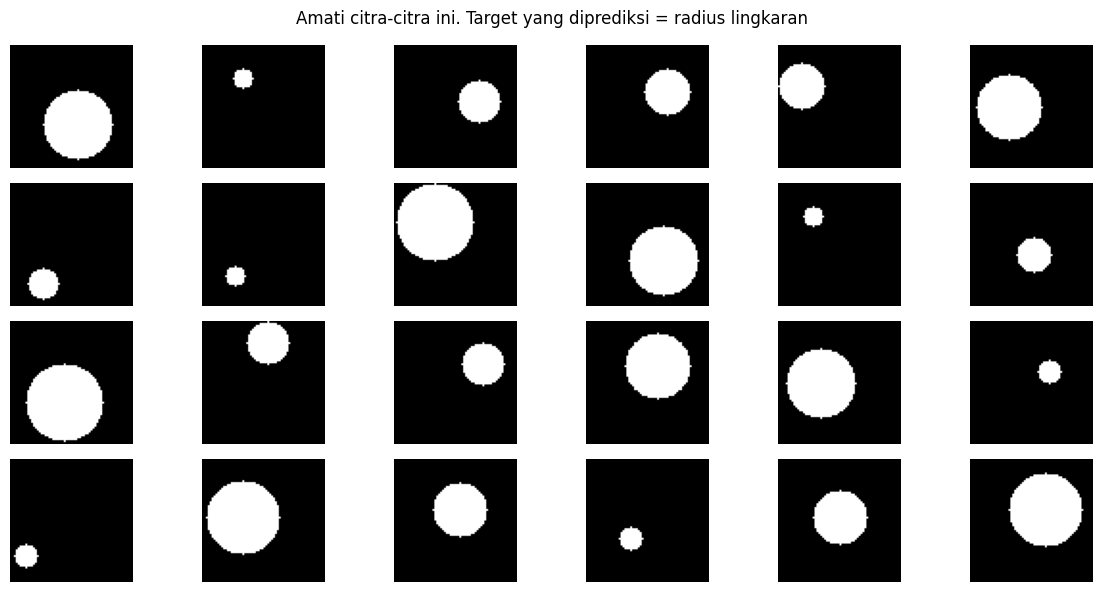

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,569 (396.75 KB)

 Trainable params: 101,569 (396.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 261ms/step - loss: 99.6264 - mae: 8.2653 - val_loss: 2.7271 - val_mae: 1.3096
Epoch 2/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 263ms/step - loss: 3.0730 - mae: 1.3774 - val_loss: 1.5661 - val_mae: 1.0026
Epoch 3/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 256ms/step - loss: 1.5576 - mae: 1.0184 - val_loss: 1.5012 - val_mae: 0.9906
Epoch 4/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 259ms/step - loss: 1.4905 - mae: 1.0054 - val_loss: 1.5587 - val_mae: 1.0498
Epoch 5/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 261ms/step - loss: 1.5205 - mae: 1.0162 - val_loss: 1.4985 - val_mae: 0.9744
Epoch 6/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 269ms/step - loss: 1.5092 - mae: 1.0011 - val_loss: 1.4153 - val_mae: 0.9806
Epoch 7/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 241ms/step - loss: 1.4636 - mae: 0.9956 - val_loss: 1.5397 - val_mae: 1.0458
Epoch 8/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 256ms/step - loss: 1.4745 - mae: 0.9996 - val_loss: 1.3966 - val_mae: 0.9783
Epoch 9/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 253ms/

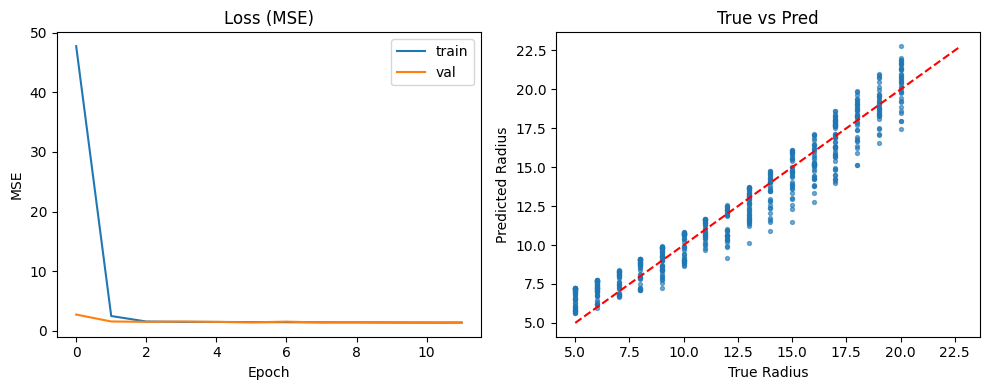

In [1]:
# D1: Prediksi Radius Lingkaran (notebook-ready)
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras import layers, models
import random
import math

# ---------- Generator sample ----------
def make_sample(img_size=64, min_r=5, max_r=20):
    r = np.random.randint(min_r, max_r + 1)  # radius
    img = np.zeros((img_size, img_size), dtype=np.uint8)
    cx = np.random.randint(r, img_size - r)
    cy = np.random.randint(r, img_size - r)
    cv2.circle(img, (cx, cy), int(r), (255,), -1)
    img = (img / 255.0).astype(np.float32)
    img3 = np.stack([img, img, img], axis=-1)  # 3-channel
    return img3, float(r), (cx, cy)

# ---------- Visualisasi beberapa sampel (Tebak target) ----------
N_show = 24
samples = [make_sample() for _ in range(N_show)]
imgs = [s[0] for s in samples]
rads = [s[1] for s in samples]

cols = 6
rows = N_show // cols
plt.figure(figsize=(12,6))
for i in range(N_show):
    plt.subplot(rows, cols, i+1)
    plt.imshow(imgs[i].squeeze(), cmap='gray')
    plt.axis('off')
plt.suptitle("Amati citra-citra ini. Target yang diprediksi = radius lingkaran")
plt.tight_layout()
plt.show()

# ---------- Buat dataset lebih besar ----------
N = 3000
data = [make_sample() for _ in range(N)]
X = np.array([d[0] for d in data], dtype=np.float32)
y = np.array([d[1] for d in data], dtype=np.float32)

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)

# ---------- Definisi model CNN sederhana ----------
def build_model():
    model = models.Sequential([
        layers.Input(shape=(64,64,3)),
        layers.Conv2D(32, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(128, 3, activation='relu'),
        layers.GlobalAveragePooling2D(),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)  # regresi
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

model = build_model()
model.summary()

# ---------- Training ----------
history = model.fit(Xtr, ytr, validation_data=(Xte, yte),
                    epochs=12, batch_size=64, verbose=1)

# ---------- Evaluasi ----------
y_pred = model.predict(Xte).ravel()
mae = mean_absolute_error(yte, y_pred)
rmse = math.sqrt(np.mean((yte - y_pred)**2))
r2 = r2_score(yte, y_pred)
print(f"D1 Results — MAE={mae:.3f} | RMSE={rmse:.3f} | R²={r2:.3f}")

# ---------- Plot history ----------
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch'); plt.ylabel('MSE'); plt.legend(); plt.title('Loss (MSE)')

plt.subplot(1,2,2)
plt.scatter(yte, y_pred, s=8, alpha=0.6)
lims = [min(yte.min(), y_pred.min()), max(yte.max(), y_pred.max())]
plt.plot(lims, lims, '--', color='red')
plt.xlabel("True Radius"); plt.ylabel("Predicted Radius"); plt.title("True vs Pred")
plt.tight_layout()
plt.show()
